# Computer Vision Programming Assingment 1
본 자료는 광주과학기술원 AI대학원 `EC5303 Computer Vision`의 `Programming Assignment 1 - Spatial Propagation using Optimization`에 대한 코드 및 정답을 포함합니다.

`Neighborhood matrix` 및 `Least square solution`, `Graph-cut`을 기반으로 하는 `Semantic segmentation`에 대한 내용입니다.

이 자료는 과제 제출을 위한 코드 정리 및 결과 보고를 위주로 작성된 결과 보고서입니다.

Python code에 대한 상세한 사용방법은 `README.md`를 참조해주시기 바랍니다.

보고서는 다음과 같은 순서로 서술되어 있습니다.

0. 패키지 및 편의성 함수
1. `Calculation of Neighborhood Matrix` Neighborhood matrix를 계산하기 위한 함수를 설명합니다.
2. `Least Square Solution` Least square solution을 위한 함수와 그 결과
3. `Calculation of IoU Score` IoU score 계산을 위한 함수와 그에 대한 least square solution의 결과
4. `Graph cut and IoU score` Graph-cut을 이용한 semantic segmentation과 그에 대한 IoU score
5. `(Option)` Extra problems

### Importing Package

전체 코드 실행에 필요한 패키지를 임포트합니다. `이미지 처리`, `행렬 연산`, `시각화`를 위한 패키지입니다.

In [16]:
# read image files
from skimage import io
import cv2
# matrix calculation
import numpy as np
from scipy import sparse
from pygco import cut_simple, cut_from_graph
# visualization
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm

### Input Image

사용되는 입력 이미지는 아래와 같습니다.

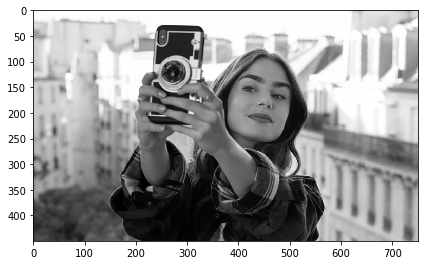

In [17]:
image = io.imread('data/Emily-In-Paris-gray.png')
io.imshow(image)

### Visualization (Image plotting)

`ground truth`와 `predicted label` 등의 이미지를 시각화 하기 위한 함수 `plot_examples`를 선언합니다.

In [18]:
def plot_examples(n, data, cmap):
    if n == 1:
        fig = plt.figure(figsize=(5, 3))
        psm = plt.pcolormesh(data, cmap=cmap)
        plt.colorbar(psm)
        plt.gca().invert_yaxis()
        plt.show()
        plt.clf()
    elif n > 1:
        fig, axs = plt.subplots(1, n, figsize=(n*5, 3),
                                constrained_layout=True, squeeze=False)
        for [ax, s] in zip(axs.flat, data):
            psm = ax.pcolormesh(
                s, cmap=cmap, rasterized=True)
            ax.invert_yaxis()
            plt.colorbar(psm, ax=ax)
        plt.show()
        plt.clf()
    else:
        raise ValueError("We can't not print negative plots.")

- - -
## Calculation of Neighborhood Matrix (6pt)

우선 `input image`로부터 `neighborhood matrix`를 얻기 위해 각 픽셀로부터 주변 픽셀이 어느 정도의 유사성을 갖는지를 통해 `weight`를 계산합니다. 이를 위해 다음과 같은 연산을 진행합니다.

1. 주어진 `threshold`를 이용하여 `neighbor pixels`를 결정한다.
2. 결정된 `neighbor pixels`에 대하여 `weight function`을 사용하여 `weight`를 결정한다.

아래에서 각각의 연산을 위해 필요한 함수를 서술합니다.

### Relative coordinates of neighbor pixels

`euclidean distance`를 기준으로 `threshold`의 거리 내에 존재할 수 있는 픽셀 들의 상대 좌표를 계산합니다.

In [19]:
def get_neighbor_indices(threshold):
    indices = set([])
    i, j = 0, 0
    while True:
        while True:
            if i == 0 and j == 0:
                j += 1
                continue
            flag = np.linalg.norm([i, j])
            if flag <= threshold:
                indices.add((i, j))
                j += 1
            else:
                break
        if j == 0:
            break
        else:
            i += 1
            j = 0
    i_neg = [(-i, j) for i, j in indices]
    j_neg = [(i, -j) for i, j in indices]
    both_neg = [(-i, -j) for i, j in indices]
    indices.update(i_neg)
    indices.update(j_neg)
    indices.update(both_neg)

    return list(indices)

### Absolute coordinate of neighbor pixels by using relative coordinate

상대 좌표를 이용해 `center pixel`이 주어졌을 때, 상대 좌표만큼 떨어져있는 `neighbor pixels`의 절대 좌표를 계산하는 함수를 정의합니다.

In [20]:
def neighborhood_pixel(x, y, width, height, n_indices):
    abs_indices = []
    for index in n_indices:
        i, j = x + index[0], y + index[1]
        if i < 0 or j < 0:
            continue
        elif i >= width or j >= height:
            continue
        else:
            abs_indices.append((i, j))

    return abs_indices

### Calculate Neighborhood matrix by using weight function

`neighbor pixels`에 대하여 `weight`를 계산하는 함수를 정의합니다.

In [21]:
def weight_func1(r, s, var):
    w = np.exp(-(r.astype(np.int32)-s.astype(np.int32))**2 / (2*var))
    return w / np.sum(w)

위에서 정의된 함수를 사용하여 다음과 같은 순서로 `neighborhood matrix`를 계산합니다.

이 때, `OOM(out of memory)` 문제를 방지하고자 `sparse matrix`를 생성합니다.

1. `center pixel`를 가져와 `index`와 `intensity(the value of pixel)`를 얻는다.
2. 상대 좌표를 이용하여 `center pixel`에 대한 `neighbor pixels`의 절대 좌표와 `intensity`를 얻는다.
3. `intensity`를 이용하여 정의된 `weight function`으로 `center pixel`에 대한 `neighbor pixels`의 `weight`를 계산한다.
4. `row`는 `index of center pixel`, `col`는 `index of neighbor pixel`, `data`는 `weight`로 하여 `sparse matrix`를 생성한다.

In [22]:
def neighborhood_weight(image, threshold):
    row_length = image.shape[0]
    col_length = image.shape[1]
    size = row_length * col_length
    row_indices = []
    col_indices = []
    data = []

    # Calculate weights of neighborhoods
    n_indices = get_neighbor_indices(threshold)
    for i, row in tqdm(enumerate(image), desc='Neighbor Matrix'):
        for j, r in enumerate(row):
            # i, j: coordinate of center pixel
            # r: intensity of center pixel
            # n: a list of neighborhood pixels
            # s: a list of intensities of neighborhood pixels
            center_index = i*col_length + j

            n = neighborhood_pixel(i, j, row_length, col_length, n_indices)
            s = np.array([image[x, y] for (x, y) in n])
            neighbor_indices = np.array([x*col_length+y for (x, y) in n])

            var = np.var(s)
            if var == 0:
                w = np.ones_like(s) / len(s)
            else:
                w = weight_func1(r, s, var)

            for index, e in enumerate(neighbor_indices):
                row_indices.append(center_index)
                col_indices.append(e)
                data.append(w[index])

    # Generate neighborhood matrix
    return sparse.coo_matrix(
        (data, (row_indices, col_indices)),
        shape=(size, size)
    )

`threshold`를 이용하여 `neighborhood matrix`를 계산합니다. 계산된 `neighborhood matrix`는 `optimization`을 위해 사용됩니다. 다음 단계의 `Least square solution`에서의 연산량을 줄이기 위하여 낮은 `threshold`를 사용했으나, `8` 정도에서 더 좋은 성능을 보였습니다.

In [23]:
threshold = 5
matrix = neighborhood_weight(image, threshold)

Neighbor Matrix: 450it [00:46,  9.75it/s]


- - -
## Least Square Solution (5pt)

target scribble image를 사용하여 neighborhood matrix로부터 semantic segmentation을 진행합니다.

주어진 scribble image는 아래와 같이 표현됩니다.

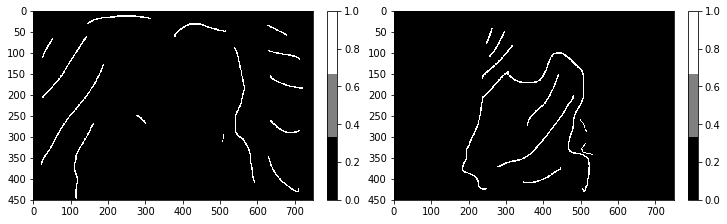

<Figure size 432x288 with 0 Axes>

In [24]:
scribble_image = cv2.imread('data/Emily-In-Paris-scribbles.png')
print_image = [np.where(scribble_image[:, :, 2] == i+1, 1., 0.) for i in range(scribble_image.max())]
plot_examples(2, print_image, cmap=cm.get_cmap('gray', 3))

`A x = b`의 수식으로부터 `x = A^-1 b`를 계산하여 정답을 얻을 수 있으므로, 주어진 `sparse matrix`에 대한 inverse matrix를 계산하기 위해 `scipy.sparse.linalg.inv()`를 사용할 수 있으나, 메모리 및 계산 시간에서 문제가 발생하는 것을 확인했습니다.

따라서 `scipy.sparse.linalg.lsqr`과 `scipy.sparse.linalg.lsmr`을 사용하여 정답을 추정합니다. 두 함수 간의 성능 차이는 미미한 것을 확인하였기 때문에 `lsqr`에 대한 결과만 서술합니다.

In [27]:
from scipy.sparse import linalg

def least_square_solution(operator, scribble, matrix, precision, show=False):
    # Original Shape
    width, height = scribble.shape[:2]
    # Matrix pre-processing
    if not isinstance(matrix, sparse.csr_matrix):
        matrix = sparse.csr_matrix(matrix)

    identity_matrix = sparse.eye(matrix.shape[0])
    matrix = identity_matrix - matrix
    # Scribble pre-processing
    scribble = scribble.reshape(-1, 3)
    scribbles = [
        np.where(scribble[:, 2] == i+1, 1., 0.) for i in range(scribble.max())
    ]
    scribbles = sparse.csr_matrix(scribbles)

    # Least-square solution
    result = []
    for s in tqdm(scribbles, desc='Least Square Solution'):
        print('\n[Update neighborhood matrix to fit with scribble]')
        s_matrix = matrix.copy()
        for ind in s.indices:
            tmp_mat = s_matrix.getrow(ind).ceil()
            tmp_mat.eliminate_zeros()
            s_matrix[ind] = tmp_mat
        print('[Calculate Least-Square Solution]')
        s = s.transpose().toarray().squeeze()
        if operator == 'lsqr':
            x, *_ = linalg.lsqr(
                s_matrix, s,
                show=show,
                atol=precision,
                btol=precision,
                conlim=0
            )
        elif operator == 'lsmr':
            x, *_ = linalg.lsmr(
                matrix, s,
                show=show,
                atol=precision,
                btol=precision,
                conlim=0
            )
        else:
            raise TypeError()
        result.append(np.expand_dims(x, axis=1))
    result = np.concatenate(result, axis=1).reshape(
        width, height, -1).transpose(2, 0, 1)
    return np.expand_dims(np.argmax(result, axis=0), axis=0)


`lsqr`을 사용하여 `scrrible`과 `input image`에 대해 `least square solution`을 얻습니다. 이 때, 추정 정밀도는 `1e-6`으로 설정하였습니다. 이보다 작은 정밀도에서는 성능이 다소 떨어지는 모습을 보였으며, 큰 정밀도에서는 필요 이상의 계산 시간이 필요하므로 다음과 같이 설정하였습니다.

In [30]:
lstsq_predicted = least_square_solution('lsqr', scribble_image, matrix, 1e-6)

Least Square Solution: 0it [00:00, ?it/s]


[Update neighborhood matrix to fit with scribble]
[Calculate Least-Square Solution]


Least Square Solution: 1it [12:15, 735.32s/it]


[Update neighborhood matrix to fit with scribble]
[Calculate Least-Square Solution]


Least Square Solution: 2it [23:34, 707.50s/it]


왼쪽은 `predicted segmentation image`, 오른쪽은 `ground truth segmentation image`입니다.

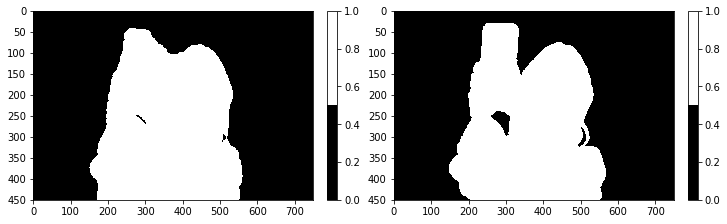

<Figure size 432x288 with 0 Axes>

In [31]:
ground_truth = cv2.imread('data/Emily-In-Paris-gt.png')

plot_examples(
    2, 
    np.concatenate([
        lstsq_predicted,
        ground_truth[np.newaxis, :, :, 2]
    ], axis=0),
    cmap=cm.get_cmap('gray', 2),
)

- - -
## Calculation of IoU Score - Least square solution (2pt)

이제 `least square solution`을 통하여 얻어진 `segmentation image`를 `ground truth`와 비교하여 `IoU score`를 계산합니다. `intersection`은 `numpy.logical_and()`, `union`은 `numpy.logical_or()`를 사용하여 계산합니다. 

In [32]:
def calculate_IoU(n_label, predicted, gt):
    gt = gt[:, :, 2]
    if n_label <= 2:
        intersection = np.logical_and(predicted, gt)
        union = np.logical_or(predicted, gt)
        iou_score = np.sum(intersection) / np.sum(union) * 100.
    elif n_label > 2:
        scores = []
        for i in range(n_label):
            t_gt = np.where(gt == i+1, 1., 0.)
            t_predicted = np.where(predicted == i+1, 1., 0.)
            intersection = np.logical_and(t_predicted, t_gt)
            union = np.logical_or(t_predicted, t_gt)
            score = np.sum(intersection) / np.sum(union) * 100.
            scores.append(score)
        iou_score = np.mean(scores)
    print(f'IoU score: {iou_score}')

약 `92.73%`의 정확도를 보였습니다.

In [33]:
calculate_IoU(2, lstsq_predicted, ground_truth)

IoU score: 92.72810742568576


- - -
## Graph-cut and IoU score (7pt)
`Graph-cut`은 다음과 같이 진행합니다.

1. 각 `label`에 대하여 `scribble`의 `intensity`의 `mean`과 `variation`을 계산한다.
2. `mean`과 `variation`을 이용하여 각 label마다 `cost`를 계산한다.
3. `pygco.cut_simple()`을 사용하여 `cost`로부터 label을 추정한다.

In [40]:
def graph_cut(n_label, input_image, scribble_image):
    scribbles = np.array([
        np.where(scribble_image[:, :, 2] == i+1, input_image, 0.) for i in range(n_label)
    ]).reshape(n_label, -1)

    mean = np.mean(scribbles, where=(scribbles != 0), axis=1, keepdims=True)
    var = np.var(scribbles, where=(scribbles != 0), axis=1, keepdims=True)
    mean = mean[:, :, np.newaxis]
    var = var[:, :, np.newaxis]

    input_image = np.broadcast_to(
        input_image[np.newaxis, :, :],
        (n_label, input_image.shape[0], input_image.shape[1])
    )

    cost = (((input_image-mean)**2) / (2*var)
            ).transpose(1, 2, 0).copy("C").astype(np.int32)

    if n_label == 2:
        pairwise = -10 * np.eye(n_label, dtype=np.int32)
    elif n_label == 7:
        x, y = np.ogrid[:n_label, :n_label]
        pairwise = 5 * np.abs(x - y).astype(np.int32).copy("C")

    return cut_simple(cost, pairwise)[np.newaxis, :, :]

In [47]:
gc_predicted = graph_cut(2, image, scribble_image)

`graph-cut`으로 추정된 이미지는 왼쪽, `ground truth`는 오른쪽입니다.

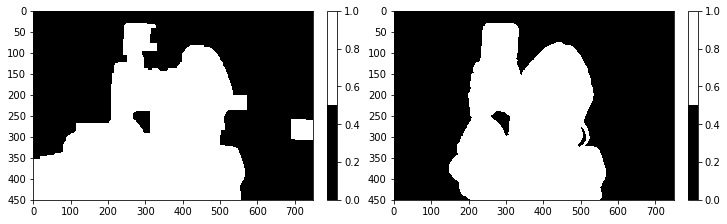

<Figure size 432x288 with 0 Axes>

In [43]:
plot_examples(
    2,
    np.concatenate([
        gc_predicted,
        ground_truth[np.newaxis, :, :, 2]
    ], axis=0),
    cmap=cm.get_cmap('gray', 2),
)

`IoU score`를 기준으로 약 `77.31%`의 정확도를 보였습니다.

In [44]:
calculate_IoU(2, gc_predicted, ground_truth)

IoU score: 77.31491962870727


- - -
## (Option) Multi-modal Graph-cut optimization

각 label에 대하여 `multi-modality`를 사용하여 최적화를 진행해봤습니다. 나누고자 하는 `modal`의 개수에 따라 주어진 `scribble`의 `intensity`를 등분할하여, 분할된 리스트에서 각각 `mean`과 `variation`을 계산합니다. 이를 이용하여 전체 `cost`를 계산합니다. 기존 코드에 `multi-modality`를 위한 코드가 추가되었습니다. 사용하는 함수는 아래와 같습니다.

In [57]:
def multimodal_graph_cut(n_label, n_modal, input_image, scribble_image):
    input_image = input_image[np.newaxis, :, :]

    scribbles = np.array([
        np.where(scribble_image[:, :, 2] == i+1, input_image, 0.) for i in range(n_label)
    ]).reshape(n_label, -1)

    # multi-modality
    if n_modal == 1:
        mean = np.mean(scribbles, where=(
            scribbles != 0), axis=1, keepdims=True)
        var = np.var(scribbles, where=(
            scribbles != 0), axis=1, keepdims=True)
        mean = mean[:, :, np.newaxis]
        var = var[:, :, np.newaxis]

        total_cost = (((input_image-mean)**2) / (2*var))
    elif n_modal > 1:
        n_modals = n_modal * np.ones(n_label, dtype=np.int32)
        total_cost = []
        for i, nm in enumerate(n_modals):
            s = scribbles[i]
            s = s[np.nonzero(s)]
            if nm == 1:
                mean = np.mean(s, keepdims=True)
                var = np.var(s, keepdims=True)
            elif nm > 1:
                mean = []
                var = []
                s_min = s.min()
                gap = (np.ptp(s)+1) / nm
                for n in range(nm):
                    part_s = s[np.logical_and(
                        s >= (s_min+n*gap), s < (s_min+(n+1)*gap))]
                    if part_s.size != 0:
                        mean.append(np.mean(part_s))
                        var.append(np.var(part_s))
                    else:
                        mean.append(0)
                        var.append(0)
                mean = np.array(mean)
                var = np.array(var)
            mean = mean[:, np.newaxis, np.newaxis]
            var = var[:, np.newaxis, np.newaxis]
            c = (-(input_image-mean)**2) / (2*var)
            c = -np.log(np.sum(np.exp(c), axis=0))
            total_cost.append(c)
        total_cost = np.array(total_cost)
    
    total_cost = total_cost.transpose(1, 2, 0).copy("C").astype(np.int32)

    if n_label == 2:
        pairwise = -10 * np.eye(n_label, dtype=np.int32)
    elif n_label == 7:
        x, y = np.ogrid[:n_label, :n_label]
        pairwise = 5 * np.abs(x - y).astype(np.int32).copy("C")

    return cut_simple(total_cost, pairwise)[np.newaxis, :, :]

`modal`을 `1`부터 `7`까지 나누어 계산했을 때의 결과 이미지입니다.

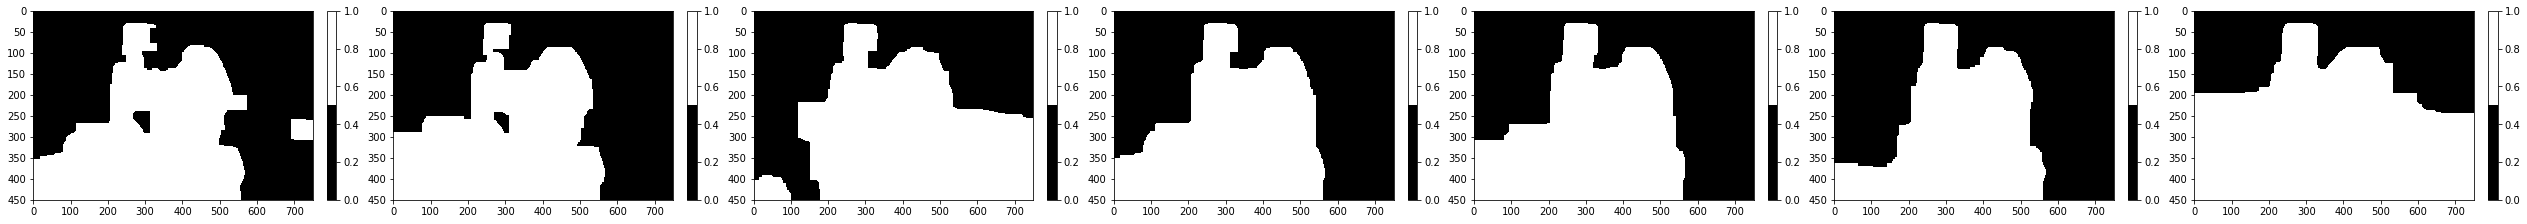

<Figure size 432x288 with 0 Axes>

In [61]:
multimodal_predicted = [
    multimodal_graph_cut(2, i+1, image, scribble_image) for i in range(7)
]
plot_examples(
    7,
    np.concatenate(multimodal_predicted, axis=0),
    cmap=cm.get_cmap('gray', 2),
)


In [83]:
for i in range(7):
    print(f'{i+1} modal ', end='')
    calculate_IoU(2, multimodal_predicted[i], ground_truth)

1 modal IoU score: 77.31491962870727
2 modal IoU score: 75.45287044834332
3 modal IoU score: 66.13217662540208
4 modal IoU score: 78.43306513434644
5 modal IoU score: 77.91576160953461
6 modal IoU score: 84.76665852211246
7 modal IoU score: 56.366759232544716


- - -
## (Option) Multi-label mIoU

여러 개의 label을 사용하여 `semantic segmentation`을 진행합니다. 이를 위하여, 동일한 이미지에 대해 7개의 label을 가진 `scribble`을 별도로 제공받았습니다. `label`은 `sky`, `buildings`, `tree`, `hair`, `skin`, `phone`, `clothes`로 구분됩니다.

### Load multi-label scribble

7개의 `label`을 가진 `scribble` 이미지에서 각각의 `scribble`을 분할 출력합니다.

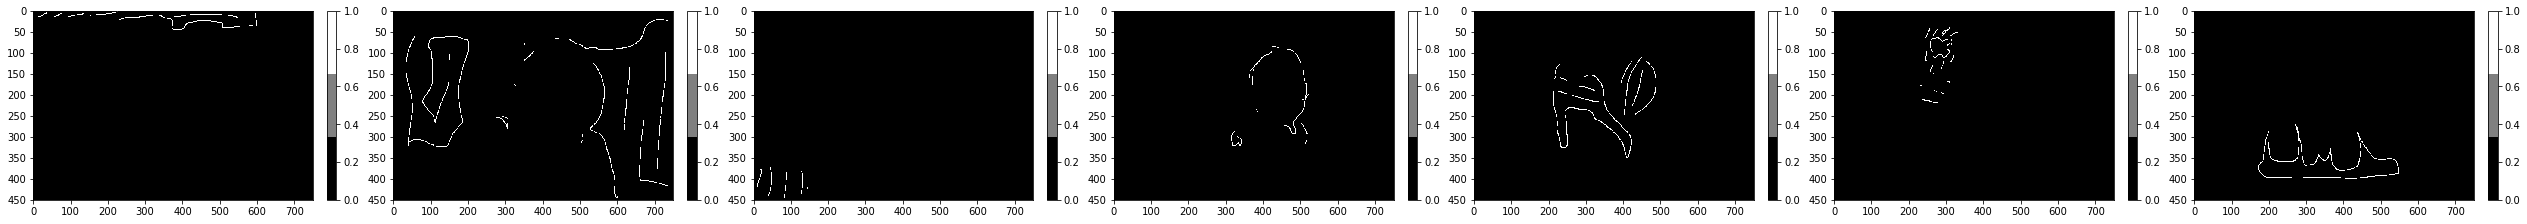

<Figure size 432x288 with 0 Axes>

In [45]:
n_label = 7
multi_scribble = cv2.imread('data/Emily-In-Paris-scribbles-plus.png')
print_image = [np.where(multi_scribble[:, :, 2] == i+1, 1., 0.)
               for i in range(multi_scribble.max())]
plot_examples(n_label, print_image, cmap=cm.get_cmap('gray', 3))

### Least square solution

위에 기술되어 있는 코드는 `label`의 크기에 상관없이 사용할 수 있도록 구현되어 있기 때문에, `multi-label scribble`을 동일한 함수에 사용하면 결과를 얻을 수 있습니다. 연산 시간을 줄이기 위하여 `1e-4`의 정밀도로 결과를 추정합니다.

In [ ]:
multi_predicted = least_square_solution('lsqr', multi_scribble, matrix, 1e-4)

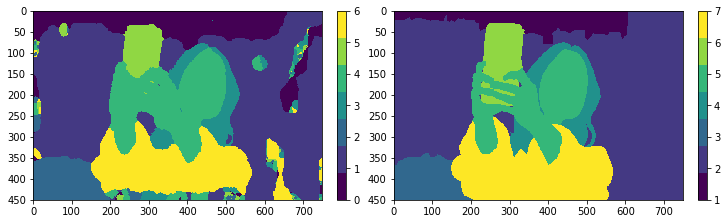

<Figure size 432x288 with 0 Axes>

In [63]:
multi_ground_truth = cv2.imread('data/Emily-In-Paris-gt-plus.png')

plot_examples(
    2,
    np.concatenate([
        multi_predicted,
        multi_ground_truth[np.newaxis, :, :, 2]
    ], axis=0),
    cmap=cm.get_cmap('viridis', n_label),
)

`label index`차이를 없애기 위해 `multi_predicted+1`을 진행하고 `mIoU score`를 측정합니다. 약 `72.00%`의 정확도를 보입니다.

In [66]:
calculate_IoU(7, multi_predicted+1, multi_ground_truth)

IoU score: 72.00855605117468


위의 결과는 `threshold = 5, precision = 1e-4`으로 진행하여 낮은 정확도를 보이나, `threshold = 8, precision = 1e-6`으로 진행할 경우, 더 높은 정확도를 얻을 수 있습니다. 해당하는 결과의 이미지만 첨부합니다.

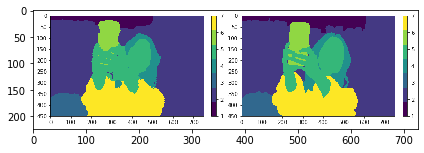

In [68]:
predicted_image = io.imread('results/lsqr_t8_w1_p1e-06_l7_output.png')
io.imshow(predicted_image)

### Graph-cut

`Graph-cut`또한 `multi-label`에서 동작 가능하도록 미리 코드가 작성되어 있으므로 위에 작성한 코드를 `label`의 수에 해당하는 인자만 변경하여 재호출합니다.

In [69]:
multi_graph_predicted = graph_cut(7, image, multi_scribble)

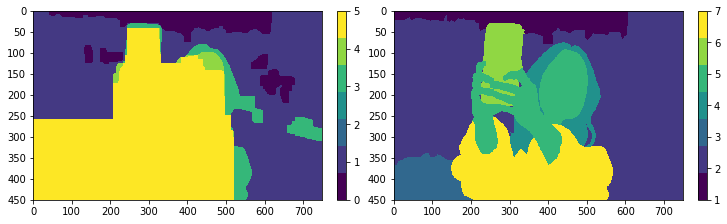

<Figure size 432x288 with 0 Axes>

In [70]:
plot_examples(
    2,
    np.concatenate([
        multi_graph_predicted,
        multi_ground_truth[np.newaxis, :, :, 2]
    ], axis=0),
    cmap=cm.get_cmap('viridis', n_label),
)

약 `24.08%`의 정확도를 보입니다.

In [71]:
calculate_IoU(7, multi_graph_predicted+1, multi_ground_truth)

IoU score: 24.08229420428006


- - -
## (Option) Multimodal Multi-label Graph-Cut Opimization

`Multi-label graph-cut`에서의 낮은 성능을 보완하기 위하여 `Multi-modality`와 `neighborhodd matrix`를 이용한 추가적인 보정을 진행했습니다.

In [72]:
def mm_graph_cut(input_image, scribble, matrix, n_label, n_modal):
    width, height = input_image.shape
    # input image pre-processing
    input_image = input_image[np.newaxis, :, :]
    # scribble pre-processing
    scribbles = np.array([
        np.where(scribble[:, :, 2] == i+1, input_image, 0.) for i in range(n_label)
    ]).reshape(n_label, -1)

    # multi-modality
    if n_modal == 1:
        mean = np.mean(scribbles, where=(
            scribbles != 0), axis=1, keepdims=True)
        var = np.var(scribbles, where=(
            scribbles != 0), axis=1, keepdims=True)
        mean = mean[:, :, np.newaxis]
        var = var[:, :, np.newaxis]

        total_cost = (((input_image-mean)**2) / (2*var))
    elif n_modal > 1:
        n_modals = n_modal * np.ones(n_label, dtype=np.int32)
        total_cost = []
        for i, nm in enumerate(n_modals):
            s = scribbles[i]
            s = s[np.nonzero(s)]
            if nm == 1:
                mean = np.mean(s, keepdims=True)
                var = np.var(s, keepdims=True)
            elif nm > 1:
                mean = []
                var = []
                s_min = s.min()
                gap = (np.ptp(s)+1) / nm
                for n in range(nm):
                    part_s = s[np.logical_and(
                        s >= (s_min+n*gap), s < (s_min+(n+1)*gap))]
                    if part_s.size != 0:
                        mean.append(np.mean(part_s))
                        var.append(np.var(part_s))
                    else:
                        mean.append(0)
                        var.append(0)
                mean = np.array(mean)
                var = np.array(var)
            mean = mean[:, np.newaxis, np.newaxis]
            var = var[:, np.newaxis, np.newaxis]
            c = (-(input_image-mean)**2) / (2*var)
            c = -np.log(np.sum(np.exp(c), axis=0))
            total_cost.append(c)
        total_cost = np.array(total_cost)

    edges = np.array(
        [matrix.row, matrix.col, matrix.data]
    ).transpose(1, 0).copy("C").astype(np.int32)

    # update cost by using neigborhood matrix
    total_cost = total_cost.transpose(1, 2, 0)
    total_cost = total_cost.reshape(-1, n_label)
    identity_matrix = sparse.eye(matrix.shape[0])
    matrix = identity_matrix + matrix
    total_cost = matrix @ total_cost
    total_cost = total_cost.reshape(width, height, n_label).copy("C").astype(np.int32)

    # graph-cut
    if n_label == 2:
        pairwise = -10 * np.eye(n_label, dtype=np.int32)
    elif n_label == 7:
        x, y = np.ogrid[:n_label, :n_label]
        pairwise = 5 * np.abs(x - y).astype(np.int32).copy("C")

    result = cut_simple(total_cost, pairwise)
    return result[np.newaxis, :, :]

In [76]:
mm_predicted = [
    mm_graph_cut(image, multi_scribble, matrix, 7, i+1) for i in range(3)
]

/tmp/ipykernel_29679/75820138.py:48: RuntimeWarning: divide by zero encountered in log
  c = -np.log(np.sum(np.exp(c), axis=0))


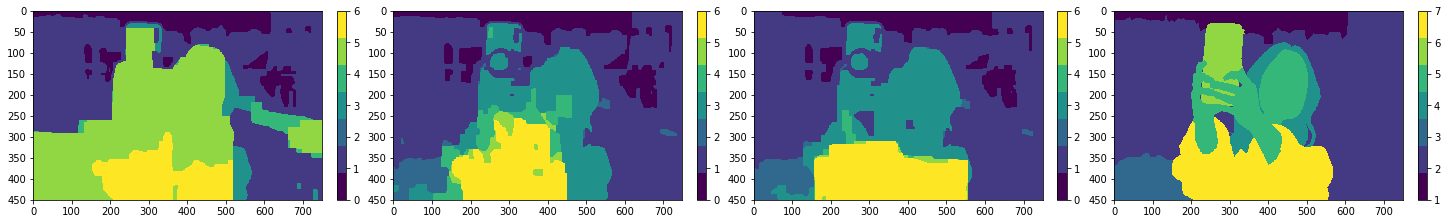

<Figure size 432x288 with 0 Axes>

In [78]:
plot_examples(
    4,
    np.concatenate([
        np.concatenate(mm_predicted, axis=0),
        multi_ground_truth[np.newaxis, :, :, 2]
    ], axis=0),
    cmap=cm.get_cmap('viridis', n_label),
)

In [84]:
for i in range(3):
    print(f'{i} modal ', end='')
    calculate_IoU(7, mm_predicted[i]+1, multi_ground_truth)

0 modal IoU score: 30.390803126533026
1 modal IoU score: 39.70438460441395
2 modal IoU score: 41.73104516624034


- - - 
## (Option) Other weight function

### Function for neighborhood matrix with other weight

`laplacian`을 이용하여 `neighborhood matrix`를 계산하는 함수를 새롭게 선언합니다.

In [85]:
def laplacian_neighborhood_weight(image, threshold):
    row_length = image.shape[0]
    col_length = image.shape[1]
    size = row_length * col_length
    row_indices = []
    col_indices = []
    data = []

    # degree matrix
    d_row = []
    d_col = []
    d_data = []

    # Calculate weights of neighborhoods
    n_indices = get_neighbor_indices(threshold)
    for i, row in tqdm(enumerate(image), desc='Neighbor Matrix'):
        for j, r in enumerate(row):
            # i, j: coordinate of center pixel
            # r: intensity of center pixel
            # n: a list of neighborhood pixels
            # s: a list of intensities of neighborhood pixels
            center_index = i*col_length + j

            n = neighborhood_pixel(i, j, row_length, col_length, n_indices)
            s = np.array([image[x, y] for (x, y) in n])
            neighbor_indices = np.array([x*col_length+y for (x, y) in n])

            mean = np.mean(s)
            var = np.var(s)
            if var == 0:
                w = np.ones_like(s) / len(s)
            else:
                w = weight_func1(r, s, var)

            d_row.append(center_index)
            d_col.append(center_index)
            d_data.append(len(n))

            for index, e in enumerate(neighbor_indices):
                row_indices.append(center_index)
                col_indices.append(e)
                data.append(w[index])

    result = sparse.coo_matrix(
        (data, (row_indices, col_indices)),
        shape=(size, size)
    )

    # Generate laplacian matrix
    degree = sparse.coo_matrix(
        (d_data, (d_row, d_col)),
        shape=(size, size)
    )
    result = degree - result

    # Generate neighborhood matrix
    return result.tocoo()

In [86]:
laplacian_matrix = laplacian_neighborhood_weight(image, 5)

Neighbor Matrix: 450it [00:49,  9.02it/s]


### Least square solution

작은 `threshold`에서는 좋은 결과를 보이지 못했기 때문에 `threshold=16`으로 정답과의 오차가 `0`이 될 때까지 수행한 결과를 출력합니다. `IoU score`는 약 `89.37%`로 계산되었습니다.

In [88]:
ow_lstsq_predicted = least_square_solution('lsqr', scribble_image, laplacian_matrix, 0)

Least Square Solution: 0it [00:00, ?it/s]


[Update neighborhood matrix to fit with scribble]
[Calculate Least-Square Solution]


Least Square Solution: 1it [02:03, 123.69s/it]


[Update neighborhood matrix to fit with scribble]
[Calculate Least-Square Solution]


Least Square Solution: 2it [04:05, 122.56s/it]


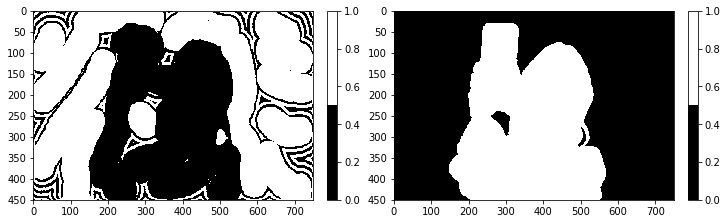

<Figure size 432x288 with 0 Axes>

In [89]:
plot_examples(
    2,
    np.concatenate([
        ow_lstsq_predicted,
        ground_truth[np.newaxis, :, :, 2]
    ], axis=0),
    cmap=cm.get_cmap('gray', 2),
)

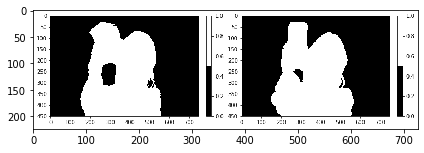

In [87]:
io.imshow(io.imread('results/lsqr_t16_laplacian_p0e+00_l2_output.png'))

### Graph-cut

동일한 `neighborhood matrix`를 사용하여 graph-cut 또한 진행합니다. `IoU score` 기준으로 약 `62.55%`의 정확도를 보였습니다.

In [90]:
ow_gc_predicted = mm_graph_cut(image, scribble_image, laplacian_matrix, 2, 1)

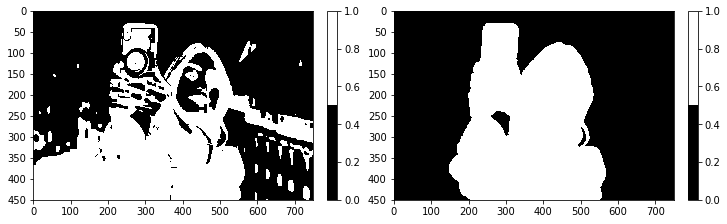

IoU score: 62.554131141507696


<Figure size 432x288 with 0 Axes>

In [92]:
plot_examples(
    2,
    np.concatenate([
        ow_gc_predicted,
        ground_truth[np.newaxis, :, :, 2]
    ], axis=0),
    cmap=cm.get_cmap('gray', 2),
)
calculate_IoU(2, ow_gc_predicted, ground_truth)